In [1]:
import math

import sys
sys.path.insert(0, '..')
#import d2l
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy
import yacht_main as yacht
import copy
import collections
import random
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import IPython as ip

In [2]:
INPUT_SIZE = 5
OUTPUT_SIZE = 12

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(INPUT_SIZE)
    
net = torch.nn.Sequential(
    Reshape(),
    
    nn.Linear(in_features=INPUT_SIZE, out_features=50),
    nn.LeakyReLU(),
    nn.Linear(50,30),
    nn.LeakyReLU(),
    nn.Linear(30,OUTPUT_SIZE)
    
    #nn.Linear(in_features=INPUT_SIZE, out_features = OUTPUT_SIZE)
)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.uniform_(m.weight,-0.1,0.1)

net = net.float()
net.apply(init_weights)

Sequential(
  (0): Reshape()
  (1): Linear(in_features=5, out_features=50, bias=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=50, out_features=30, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=30, out_features=12, bias=True)
)

In [3]:
def try_gpu():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = try_gpu()
print(torch.cuda.is_available())
net = net.to(device)

True


train_data = []
SCALE = 30.0


def pack(org):
    return (org/SCALE)

def unpack(norm):
    return round(SCALE*float(norm))

for d1 in range(6):
    for d2 in range(6):
        for d3 in range(6):
            for d4 in range(6):
                for d5 in range(6):
                    dices = [d1+1,d2+1,d3+1,d4+1,d5+1]
                    scores = [pack(f(dices)) for f in yacht.score_func]
                    #scores = [yacht.score_func[6](dices)/SCALE]
                    
                    dt = torch.tensor([dices.count(i+1) for i in range(6)], dtype = torch.float32, requires_grad = False)
                    st = torch.tensor(scores, dtype = torch.float32, requires_grad = False)
                    
                    train_data.append((dt,st))

print(str(len(train_data)))

for x,y in train_data:
    cont = ""
    for a in x:
        cont += str(int(a))+" "
    cont += " | "
    for b in y:
        cont += str(unpack(b))+" "
    print(cont)


# DQN

In [4]:
BATCH_SIZE = 128
MEMORY_SIZE = 10000
GAMMA = 0.1
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 500
TARGET_UPDATE = 20
SCALE = 30.0
#ALPHA = 0.1

D_INPUT_SIZE = 13+6
D_OUTPUT_SIZE = 12+31

class D_Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(D_INPUT_SIZE)

policy_net = torch.nn.Sequential(
    D_Reshape(),
    nn.Linear(in_features=D_INPUT_SIZE, out_features=300),
    nn.LeakyReLU(),
    nn.Linear(300,100),
    nn.LeakyReLU(),
    nn.Linear(100,50),
    nn.LeakyReLU(),
    nn.Linear(50,D_OUTPUT_SIZE)
)

policy_net.apply(init_weights)
target_net = copy.deepcopy(policy_net)
target_net.eval()

policy_net.to(device)
target_net.to(device)


Sequential(
  (0): D_Reshape()
  (1): Linear(in_features=20, out_features=300, bias=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=300, out_features=100, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=100, out_features=50, bias=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): Linear(in_features=50, out_features=43, bias=True)
)

In [5]:
Transition = collections.namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    
    
memory = ReplayMemory(MEMORY_SIZE)

# Training

PRIORITY = 3

def train(net, train_iter,criterion, num_epochs, device,lr=None, weight_decay = 0):

    print('training on', device)
    net.to(device)
    #optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay = weight_decay)
    optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay = weight_decay)
    
    for epoch in range(num_epochs):
        #train_l_sum = torch.tensor([0.0], dtype=torch.float32, device=device)
        #train_loss_sum = torch.tensor([0.0], dtype=torch.float32, device=device)
        train_l_sum = 0.0
        train_loss_sum = 0.0
        
        
        n, start = 0, time.time()

        for x, y in train_iter:
            net.train()
            optimizer.zero_grad()
            x,y = x.to(device),y.to(device)
            
            y_hat = net(x)
            loss = criterion(y[:7], y_hat[:7]) + PRIORITY * criterion(y[7:],y_hat[7:])
            #loss = criterion(torch.atanh(y), torch.atanh(y_hat))
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_l_sum += loss.float()
                train_loss_sum += sum([abs(unpack(d)) for d in (y-y_hat)])
                n += 1


        print('epoch %d, loss %.4f, train loss %.3f, time %.1f sec, n=%d' %
              (epoch + 1, train_l_sum/n*SCALE, train_loss_sum/n, time.time() - start, n) )
    return

criterion = nn.MSELoss(reduction = 'sum')
train(net, train_data, criterion,1000, device, 0.001)

torch.save(net.state_dict(), './data/HM_learn_scores_' + str(2))

net.load_state_dict(torch.load('./data/HM_learn_scores_1'))

corr = 0

for x,y in train_data:
    net.eval()
    x,y = x.to(device),y.to(device)
    y_hat = net(x)

    hy = y.clone().detach()
    hyh = y_hat.clone().detach()
    
    dh = (hy-hyh)
    
    flag = False

    
    for i in range(OUTPUT_SIZE):
        if not unpack(dh[i]) == 0:
            flag = True
            break
    
    if not flag:
        corr += 1
        continue
    
    cont = ""
    for a in x:
        cont += str(int(a)) + " "
    cont += " | "
    for d in hy-hyh:
    #for d in hyh:
        cont += str(unpack(d)) + " "
    print(cont)
        
print("{0}".format(corr))


# DQN Training

In [6]:
steps_done = [0]
def select_action(Qv, is_step = False, with_random = True):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done[0] / EPS_DECAY)
    
    if is_step:
        steps_done[0] += 1

    if not with_random or sample > eps_threshold:
        with torch.no_grad():
            return int(torch.argmax(Qv,0))
    else:
        return torch.tensor([[random.randrange(D_OUTPUT_SIZE)]], device=device, dtype=torch.long)



In [7]:
episode_scores = []

def plot_scores():
    plt.figure(2)
    plt.clf()
    scores_t = torch.tensor(episode_scores, dtype=torch.float32)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(scores_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(scores_t) >= 10:
        means = scores_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy())

    ip.display.clear_output(wait=True)
    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤

In [8]:
def optimize_step(pol_net, tar_net, optimizer, criterion):
    if len(memory) < BATCH_SIZE:
        return
    
    batch = memory.sample(BATCH_SIZE)
    #batch = Transition(*zip(*transitions))
    
    optimizer.zero_grad()
    loss = 0
    
    for transition in batch:
        Q_state = pol_net(transition.state)
        Q_next_max = 0 if transition.next_state == None else torch.max(tar_net(transition.next_state),0)[0]
        expected_action_value = Q_next_max * GAMMA + transition.reward
        
        loss += criterion(Q_state[transition.action].view(1), expected_action_value)
        #print("{0}<<left | right>>{1}".format(Q_state[transition.action-31], expected_action_value))
        
    loss.backward()
    optimizer.step()

In [9]:

def D_train(pol_net, tar_net, criterion, num_episodes, device,lr=None, weight_decay = 0, saveidx=0):
    
    optimizer = optim.SGD(pol_net.parameters(),lr=lr)
    pol_net.train()
    start_time = time.time()
    
    for i_episode in range(num_episodes):
        
        yacht.reset_game()
        state, score, _ = yacht.get_yacht_output()
        state = torch.tensor(state, dtype=torch.float32, device=device, requires_grad = False)
        
        
        while True:
            Qv = pol_net(state)
            action = select_action(Qv, is_step = True)
            reward = yacht.update(action)/SCALE

            new_state, new_score, done = yacht.get_yacht_output()
            step_reward = torch.tensor([float(reward)], device=device, requires_grad = False)

            if not done:
                new_state = torch.tensor(new_state, dtype=torch.float, device=device, requires_grad = False)
            else:
                new_state = None
            
            memory.push(state,action,new_state,step_reward)

            state = new_state
            score = new_score


            if done:
                state, score, _ = yacht.get_yacht_output()
                episode_scores.append(score)
                #print("{0}) {1}\tscore : {2}, turns = {3}".format(i_episode, state[:12], score, t+1))

                if i_episode % 10 == 9:
                    plot_scores()
                    print("episode {0}, time elapsed: {1}s".format(i_episode, round(time.time() - start_time,1)))
                    start_time = time.time()

                break
        
        optimize_step(pol_net, tar_net, optimizer,criterion)
        optimize_step(pol_net, tar_net, optimizer,criterion)
        optimize_step(pol_net, tar_net, optimizer,criterion)
        optimize_step(pol_net, tar_net, optimizer,criterion)

        #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
        
        if i_episode % TARGET_UPDATE == 0:
            tar_net.load_state_dict(pol_net.state_dict())
        if i_episode % 1000 == 999:
            saveidx += 1
            torch.save(pol_net.state_dict(), './data/HM_DQN2/' + str(saveidx))

        
        #print("episode {0} finished".format(i_episode))

    print('Complete')

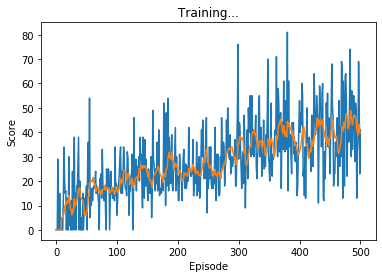

episode 200, time elapsed: 17.7s


KeyboardInterrupt: 

In [14]:
criterion = nn.MSELoss()
GAMMA=0.2
D_train(policy_net, target_net, criterion, 1000,device, lr = 0.0001, saveidx = 0)